# Retrieval

Retrieval is the centerpiece of our retrieval augmented generation (RAG) flow. 

Let's get our vectorDB from before.

## Vectorstore retrieval

In [2]:
import os
import openai
import sys
from IPython.display import Image

os.environ['OPENAI_API_KEY'] = "Replace with your API Key"
openai.api_key  = os.environ['OPENAI_API_KEY']

In [3]:
!pip install lark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.9 MB/s eta 0:00:00


### Similarity Search

In [4]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = '../docs/chroma/'

In [5]:
embedding = OpenAIEmbeddings()
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
)

/Users/peterhou/DataScienceLife/env/langchain_tutorial/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [6]:
print(vectordb._collection.count())

209


In [10]:
texts = [
    """The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).""",
    """A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.""",
    """A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.""",
]

In [11]:
smalldb = Chroma.from_texts(texts, embedding=embedding)

In [12]:
question = "Tell me about all-white mushrooms with large fruiting bodies"

In [13]:
smalldb.similarity_search(question, k=2)

[Document(page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.'),
 Document(page_content='The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).')]

In [14]:
smalldb.max_marginal_relevance_search(question,k=2, fetch_k=3)

[Document(page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.'),
 Document(page_content='A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.')]

### Addressing Diversity: Maximum marginal relevance

Last class we introduced one problem: how to enforce diversity in the search results.
 
`Maximum marginal relevance` strives to achieve both relevance to the query *and diversity* among the results.

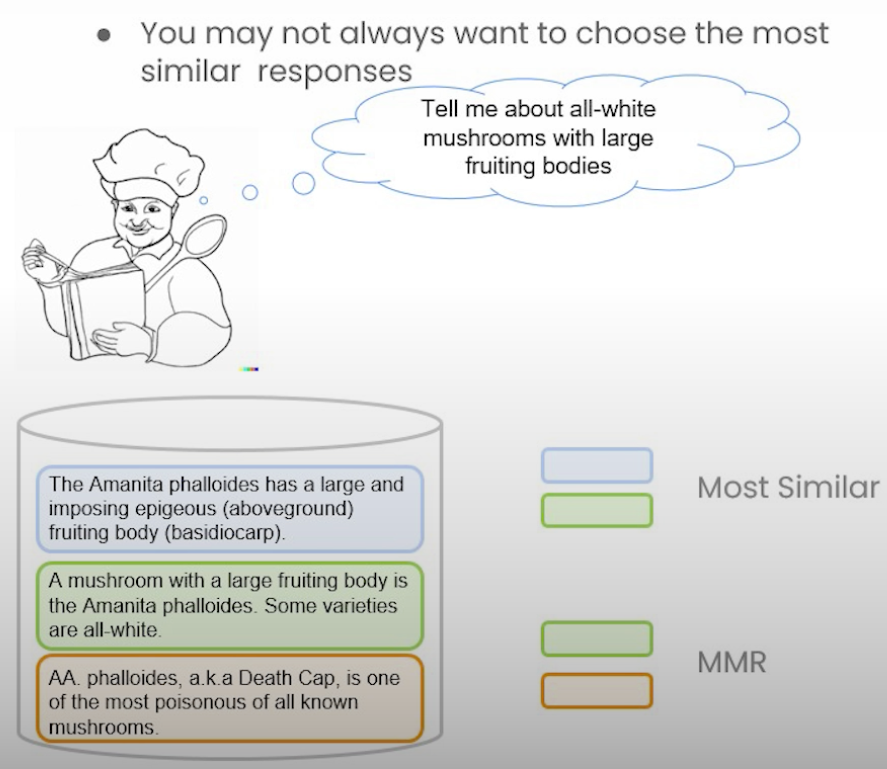

In [50]:
Image("../images/MMR example.png")

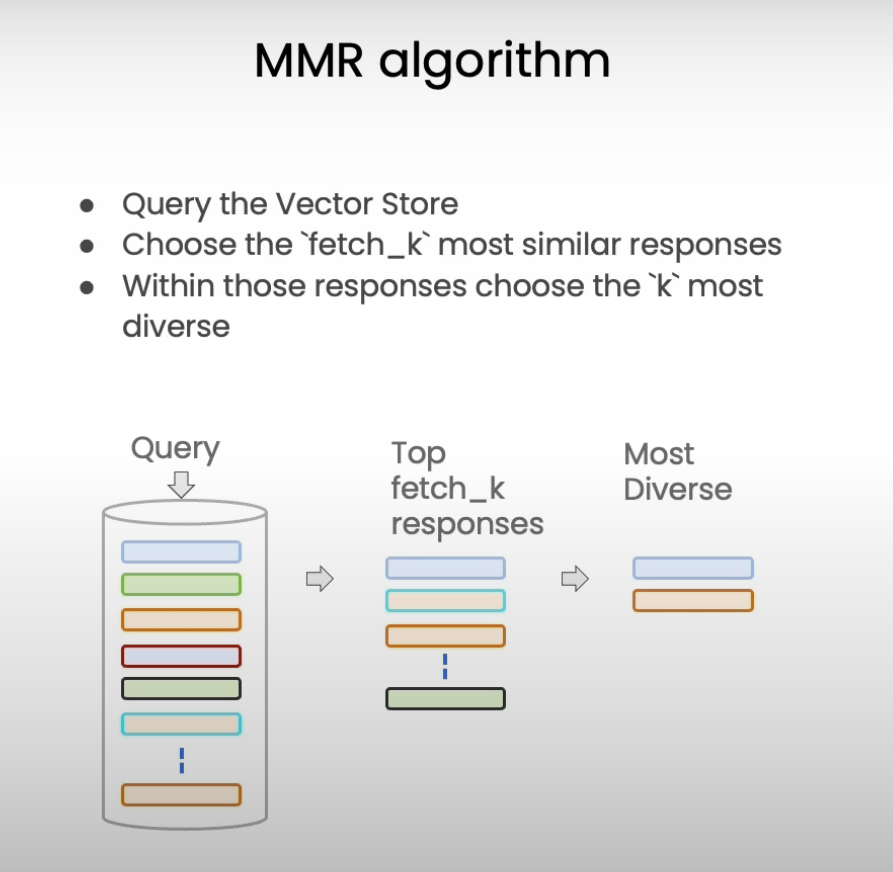

In [49]:
Image("../images/MMR.png")

In [15]:
question = "what did they say about matlab?"
docs_ss = vectordb.similarity_search(question,k=3)

In [16]:
docs_ss[0].page_content[:100]

'those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people '

In [17]:
docs_ss[1].page_content[:100]

'those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people '

Note the difference in results with `MMR`.

In [18]:
docs_mmr = vectordb.max_marginal_relevance_search(question,k=3)

In [19]:
docs_mmr[0].page_content[:100]

'those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people '

In [20]:
docs_mmr[1].page_content[:100]

'algorithm then? So what’s different? How come  I was making all that noise earlier about \nleast squa'

### Addressing Specificity: working with metadata

In last lecture, we showed that a question about the third lecture can include results from other lectures as well.

To address this, many vectorstores support operations on `metadata`.

`metadata` provides context for each embedded chunk.

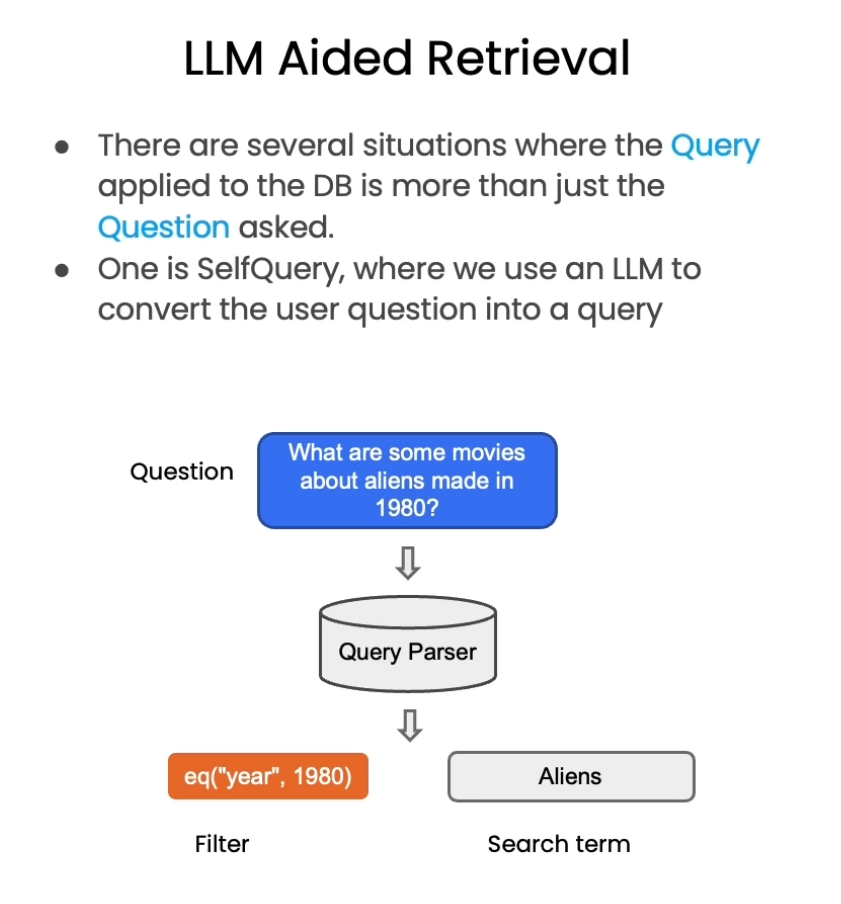

In [51]:
Image("../images/SelfQueryLLM.png")

In [21]:
question = "what did they say about regression in the third lecture?"

In [32]:
docs = vectordb.similarity_search(
    question,
    k=3,
    filter={"source":"../docs/cs229_lectures/MachineLearning-Lecture03.pdf"}
)

In [33]:
for d in docs:
    print(d.metadata)

{'page': 0, 'source': '../docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 14, 'source': '../docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 4, 'source': '../docs/cs229_lectures/MachineLearning-Lecture03.pdf'}


### Addressing Specificity: working with metadata using self-query retriever

But we have an interesting challenge: we often want to infer the metadata from the query itself.

To address this, we can use `SelfQueryRetriever`, which uses an LLM to extract:
 
1. The `query` string to use for vector search
2. A metadata filter to pass in as well

Most vector databases support metadata filters, so this doesn't require any new databases or indexes.

In [24]:
from langchain.llms import OpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

In [34]:
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The lecture the chunk is from, should be one of `docs/cs229_lectures/MachineLearning-Lecture01.pdf`, `docs/cs229_lectures/MachineLearning-Lecture02.pdf`, or `../docs/cs229_lectures/MachineLearning-Lecture03.pdf`",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the lecture",
        type="integer",
    ),
]

**Note:** The default model for `OpenAI` ("from langchain.llms import OpenAI") is `text-davinci-003`. Due to the deprication of OpenAI's model `text-davinci-003` on 4 January 2024, you'll be using OpenAI's recommended replacement model `gpt-3.5-turbo-instruct` instead.

In [35]:
document_content_description = "Lecture notes"
llm = OpenAI(model='gpt-3.5-turbo-instruct', temperature=0)
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectordb,
    document_content_description,
    metadata_field_info,
    verbose=True
)

In [36]:
question = "what did they say about regression in the third lecture?"

**You will receive a warning** about predict_and_parse being deprecated the first time you executing the next line. This can be safely ignored.

In [37]:
docs = retriever.get_relevant_documents(question)

In [38]:
for d in docs:
    print(d.metadata)

{'page': 14, 'source': '../docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 10, 'source': '../docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 0, 'source': '../docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 10, 'source': '../docs/cs229_lectures/MachineLearning-Lecture03.pdf'}


### Additional tricks: compression

Another approach for improving the quality of retrieved docs is compression.

Information most relevant to a query may be buried in a document with a lot of irrelevant text. 

Passing that full document through your application can lead to more expensive LLM calls and poorer responses.

Contextual compression is meant to fix this. 

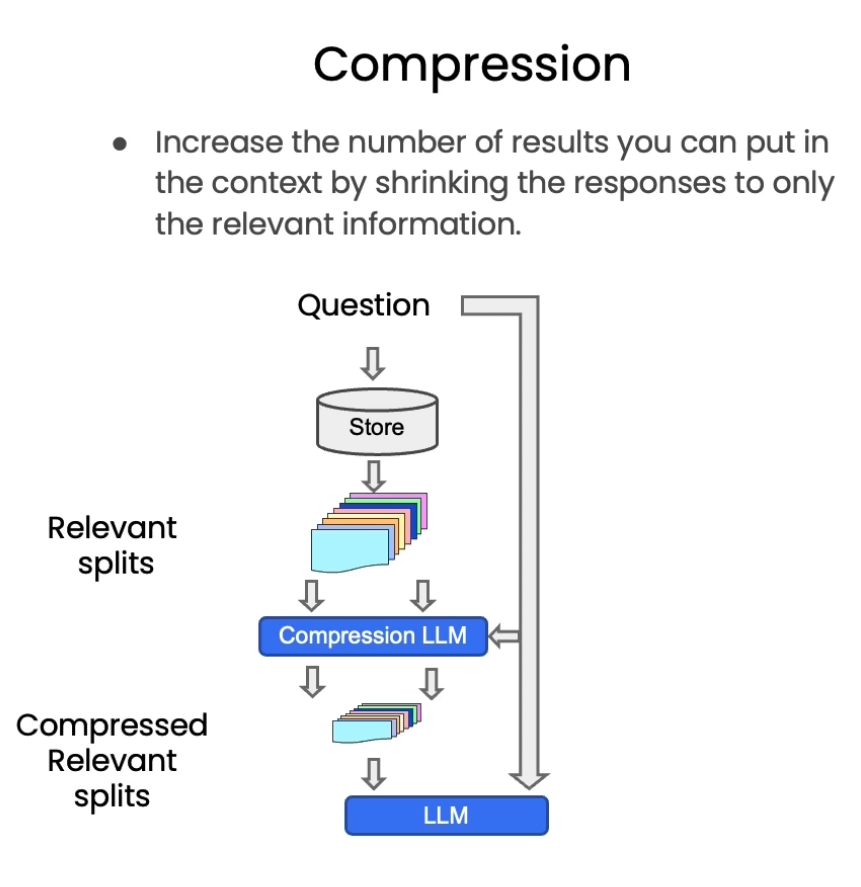

In [52]:
Image("../images/Compression.png")

In [39]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

In [40]:
def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))

In [41]:
# Wrap our vectorstore
llm = OpenAI(temperature=0, model="gpt-3.5-turbo-instruct")
compressor = LLMChainExtractor.from_llm(llm)

In [42]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever()
)

In [43]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

/Users/peterhou/DataScienceLife/env/langchain_tutorial/lib/python3.12/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/Users/peterhou/DataScienceLife/env/langchain_tutorial/lib/python3.12/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/Users/peterhou/DataScienceLife/env/langchain_tutorial/lib/python3.12/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/Users/peterhou/DataScienceLife/env/langchain_tutorial/lib/python3.12/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Document 1:

- "those homeworks will be done in either MATLA B or in Octave"
- "I know some people call it a free ve rsion of MATLAB"
- "MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to plot data."
- "there's also a software package called Octave that you can download for free off the Internet."
- "it has somewhat fewer features than MATLAB, but it's free, and for the purposes of this class, it will work for just about everything."
- "once a colleague of mine at a different university, not at Stanford, actually teaches another machine learning course."
----------------------------------------------------------------------------------------------------
Document 2:

- "those homeworks will be done in either MATLA B or in Octave"
- "I know some people call it a free ve rsion of MATLAB"
- "MATLAB is I guess part of the programming language that makes it very easy to write 

Above have duplicated documents found, we can combina MMR and Compression together to fix this problem

## Combining various techniques

In [44]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever(search_type = "mmr")
)

In [45]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

/Users/peterhou/DataScienceLife/env/langchain_tutorial/lib/python3.12/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/Users/peterhou/DataScienceLife/env/langchain_tutorial/lib/python3.12/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/Users/peterhou/DataScienceLife/env/langchain_tutorial/lib/python3.12/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/Users/peterhou/DataScienceLife/env/langchain_tutorial/lib/python3.12/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Document 1:

- "those homeworks will be done in either MATLA B or in Octave"
- "I know some people call it a free ve rsion of MATLAB"
- "MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to plot data."
- "there's also a software package called Octave that you can download for free off the Internet."
- "it has somewhat fewer features than MATLAB, but it's free, and for the purposes of this class, it will work for just about everything."
- "once a colleague of mine at a different university, not at Stanford, actually teaches another machine learning course."
----------------------------------------------------------------------------------------------------
Document 2:

"Oh, it was the MATLAB."
----------------------------------------------------------------------------------------------------
Document 3:

- learning algorithms to teach a car how to drive at reasonably high 

## Other types of retrieval

It's worth noting that vectordb as not the only kind of tool to retrieve documents. 

The `LangChain` retriever abstraction includes other ways to retrieve documents, such as TF-IDF or SVM.

In [46]:
from langchain.retrievers import SVMRetriever
from langchain.retrievers import TFIDFRetriever
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [48]:
# Load PDF
loader = PyPDFLoader("../docs/cs229_lectures/MachineLearning-Lecture01.pdf")
pages = loader.load()
all_page_text=[p.page_content for p in pages]
joined_page_text=" ".join(all_page_text)

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1500,chunk_overlap = 150)
splits = text_splitter.split_text(joined_page_text)

In [ ]:
# Retrieve
svm_retriever = SVMRetriever.from_texts(splits,embedding)
tfidf_retriever = TFIDFRetriever.from_texts(splits)

In [ ]:
question = "What are major topics for this class?"
docs_svm=svm_retriever.get_relevant_documents(question)
docs_svm[0]

In [ ]:
question = "what did they say about matlab?"
docs_tfidf=tfidf_retriever.get_relevant_documents(question)
docs_tfidf[0]